# ROI Detection Final

In [1]:
# import libraries
# libraries for ImageType derivation (mostly just pandas dataframe manipulations)
import os
import numpy as np
import pandas as pd

# libraries for checking mammo image to ROI image
import SimpleITK as sitk
from skimage.transform import resize
from skimage.util import compare_images

# needed for spot-mag detection
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset

# other libraries for ROI detection and inference
import sys
sys.path.insert(1, '/home/jupyter-jjjeon3/models/')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import seaborn as sn
import pathlib
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import random
import io
import cv2
import imageio
import glob
import math
import shutil
import scipy.misc
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

import wandb

%matplotlib inline

# Running ImageType extraction first (on new kheiron set)

In [2]:
# formuating the final code to add the image types and derived laterality or position

def derive_imgType(dataframe):
    # initializing empty lists:
    DeriveFlag = []  # ImageLaterality: 0 (not derived), 1 (derived), 2 (need to derive)
    ImageLateralityFinal = []  # the image laterality either copied or taken from series description
    FinalImageType = []  # final image type: 2D, 3D, cview, ROI_SSC, ROI_SS, Other (not any of the other ones)

    for index, row in dataframe.iterrows():  # iterating over all rows
        try:
            desc = row['SeriesDescription'].split(' ')  # splitting up the series description for checking
        except:
            DeriveFlag.append(2)  # update derive flag = 0 
            ImageLateralityFinal.append(np.nan)  # update final ImageLaterality
            FinalImageType.append('other')  # update imagetype
            continue
        if row['ImageLaterality'] in ['L', 'R']:  # if lat exists, it's either 2D or cview or ROI
            if 'C-View' in desc:  # if it has C-View it's cview
                DeriveFlag.append(0)  # update derive flag = 0 
                ImageLateralityFinal.append(row['ImageLaterality'])  # update final ImageLaterality
                FinalImageType.append('cview')  # update imagetype
            else:  # if it has lat and is not cview, it's 2d
                DeriveFlag.append(0)  # update derive flag = 0 
                ImageLateralityFinal.append(row['ImageLaterality'])  # update final ImageLaterality
                FinalImageType.append('2D')  # update imagetype
        else:  # if lat doesn't exist, it's either 3D, ROI
            if 'Tomosynthesis' in desc:  # if it has Tomosynthesis Reconstruction is 3D
                DeriveFlag.append(1)  # update derive flag = 1
                ImageLateralityFinal.append(desc[0])  # update final ImageLaterality
                FinalImageType.append('3D')  # update imagetype
            elif 'Capture' in desc:  # if it has Secondary Capture, it's SecurView Secondary Capture ROI
                DeriveFlag.append(2)  # update derive flag = 1
                ImageLateralityFinal.append(np.nan)  # update final ImageLaterality
                FinalImageType.append('ROI_SSC')  # update imagetype
            elif 'Screen Save' in desc:
                DeriveFlag.append(2)  # update derive flag = 1
                ImageLateralityFinal.append(np.nan)  # update final ImageLaterality
                FinalImageType.append('ROI_SS')  # update imagetype
            else:
                DeriveFlag.append(2)  # update derive flag = 1
                ImageLateralityFinal.append(np.nan)  # update final ImageLaterality
                FinalImageType.append('other')  # update imagetype
            
    dataframe['LateralityDeriveFlag'] = DeriveFlag
    dataframe['ImageLateralityFinal'] = ImageLateralityFinal
    dataframe['FinalImageType'] = FinalImageType
    
    return dataframe

# add spot mags to eithe this column or another column as "special-case/spot-mag" 
# - run roi extractions in 2D and SSC that are not spot-mags

In [3]:
# code to correct kheiron pathing
def correct_paths(dataframe):
    correct_png_path = []
    for i in dataframe.png_path.to_list():
        path = i.strip() # remove any whitespace
        path = path.replace('//', '/')  #remove any double //
        path = path.replace('/home', '') # remove /home
        path = path.strip() # remove any whitespace
        path = path.replace('/opt/ssd-data/', '/data/') # remove the opt/ssd-data
        path = path.replace('png_kheiron/cohort_1', 'png_kheiron/kheiron_code/cohort_1')
        correct_png_path.append(path)
    dataframe['png_path'] = correct_png_path

    path = []
    filename = []
    for i in dataframe.png_path.to_list():
        # kheiron cohort csv has weird paths, need to correct a bit to match the hiti server
        path.append('/'.join(i.split('/')[:-1]))
        filename.append(i.split('/')[-1])
    dataframe['path'] = path
    dataframe['filename'] = filename
    print(dataframe.png_path[0])
    print(dataframe.path[0])
    print(dataframe.filename[0])
    
    return dataframe

In [4]:
# extracting for Kheiron cohort 1
merged = pd.read_csv('/data/mammo/png_kheiron/kheiron_code/cohort_1/metadata_anon_cohort_1.csv', low_memory=False)
# kheiron 2
#merged = pd.read_csv('/data/mammo/png_kheiron/cohort_2/df_merged_anon_cohort_2.csv', low_memory=False)
merged.head()

,Unnamed: 0,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,BodyPartExamined,...,0_IconImageSequence_Rows,0_IconImageSequence_SamplesPerPixel,VOILUTFunction,WindowCenterWidthExplanation,DetectorDescription,png_path,png_path_old,empi_anon,acc_anon,study_date_anon
0,0,[],93624.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,NaN,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,66685715,7208547536889815,2017-05-15 00:00:00
1,1,[],135938.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,NaN,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00
2,2,[],NaN,Breast,T-04000,SRT,TUNGSTEN,16.0,10.0,BREAST,...,NaN,NaN,NaN,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00
3,3,[],135833.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,NaN,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00
4,4,[],NaN,Breast,T-04000,SRT,TUNGSTEN,16.0,10.0,BREAST,...,NaN,NaN,NaN,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00


In [5]:
# derive the final image types
merged = derive_imgType(merged)
merged.head()

,Unnamed: 0,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,BodyPartExamined,...,WindowCenterWidthExplanation,DetectorDescription,png_path,png_path_old,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType
0,0,[],93624.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,66685715,7208547536889815,2017-05-15 00:00:00,0,L,2D
1,1,[],135938.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D
2,2,[],NaN,Breast,T-04000,SRT,TUNGSTEN,16.0,10.0,BREAST,...,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,cview
3,3,[],135833.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D
4,4,[],NaN,Breast,T-04000,SRT,TUNGSTEN,16.0,10.0,BREAST,...,NaN,NaN,/opt/ssd-data/mammo/png_kheiron/cohort_1/extr...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,cview


In [6]:
print(merged.FinalImageType.value_counts())

2D         180376
3D          91920
cview       57085
ROI_SSC      3174
other        1585
Name: FinalImageType, dtype: int64


In [7]:
mergeddf_ssc = merged[merged.FinalImageType == 'ROI_SSC'].reset_index(drop=True).copy()
mergeddf_ssc.head()
print(mergeddf_ssc.png_path[0])

 /opt/ssd-data/mammo/png_kheiron/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c611328bce0a2.png


In [8]:
mergeddf_ssc = correct_paths(mergeddf_ssc)

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c611328bce0a2.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483
c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c611328bce0a2.png


In [9]:
mergeddf_2d = merged[merged.FinalImageType == '2D'].reset_index(drop=True).copy()
mergeddf_2d.head()
print(mergeddf_2d.png_path[0])

 /opt/ssd-data/mammo/png_kheiron/cohort_1/extracted-images/e8957017d28da3033157289d640067281a6d15a34a3318fe5a4b2645/6040636f03f9e94183171b0e23d4a8f5bf19e94f98fe53eee3e20931/b9c9d54f8480da0dae0269f2e56b5c56e44133143093bf2d81e0b43c.png


In [10]:
mergeddf_2d = correct_paths(mergeddf_2d)

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/e8957017d28da3033157289d640067281a6d15a34a3318fe5a4b2645/6040636f03f9e94183171b0e23d4a8f5bf19e94f98fe53eee3e20931/b9c9d54f8480da0dae0269f2e56b5c56e44133143093bf2d81e0b43c.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/e8957017d28da3033157289d640067281a6d15a34a3318fe5a4b2645/6040636f03f9e94183171b0e23d4a8f5bf19e94f98fe53eee3e20931
b9c9d54f8480da0dae0269f2e56b5c56e44133143093bf2d81e0b43c.png


# running spot-mag detection

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def load_img_infer(img_path, inputsize):
    # convert to PIL image
    image = Image.open(img_path)
    # make array
    array = np.array(image)
    # make grayscale into 3 channels
    img_3ch = np.stack((array,) * 3, axis=-1)
    # convert to PIL image
    image = Image.fromarray(img_3ch, mode='RGB')
    transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(inputsize),
                                transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
    return transform(image)

def show_images(image_paths, size=5):
    f = plt.figure(figsize=(30,30))
    for image_path in image_paths:
        roi_path = os.path.join(image_path)
        roi_sitk = sitk.ReadImage(roi_path)
        roi_np = sitk.GetArrayFromImage(roi_sitk)
        f.add_subplot(size, size, i+1)
        plt.imshow(roi_np, cmap='gray')
    plt.show()

def classify(model, path_name, input_size, device):
    outputs = model(torch.unsqueeze(load_img_infer(path_name, input_size), 0).to(device))
    softmax = nn.Softmax(dim=1)
    score = softmax(outputs)
    if score[:, 1] > 0.5:
        return 1
    else:
        return 0

In [12]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"
# Number of classes in the dataset
num_classes = 2
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Flag for feature extracting.
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.to(device)

base_path = '/home/jupyter-jjjeon3/Collaboratory/Jason_BR0/spot_mag_classification/'
model_ft.load_state_dict(torch.load(os.path.join(base_path, '{}.state_dict'.format(model_name))))
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [13]:
# add spot-mag column to mergeddf_ssc - already done

#spotmag_ssc = []
#for i in range(len(mergeddf_ssc)):
#    path_name = mergeddf_ssc.path[i] + '/' + mergeddf_ssc.filename[i]
#    spotmag_ssc.append(classify(model_ft, path_name, input_size, device))
#
#mergeddf_ssc['spot-mag'] = spotmag_ssc
#mergeddf_ssc.head()

,Unnamed: 0,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,BodyPartExamined,...,png_path_old,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename,spot-mag
0,100,NaN,84025.716,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,27942877,4378856307268605,2015-04-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c61...,0
1,358,NaN,143644.457,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,976c4edc8b03490104da995116cd8ec7f4b6e511a3a0c3...,0
2,363,NaN,143644.458,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,cfd759deb15ba975a087b60869fd9efcdf82a08345e885...,0
3,370,NaN,143644.460,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,087b65d2a49ee7ac0f38df44ec4a0fdd001330ce6b3801...,0
4,442,NaN,80603.015,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,21827263,7745120485365371,2017-12-07 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,333ba5ab8dc3581a62ba92c096bb578a6c5c3afc6d87bd...,0


In [ ]:
# mergeddf_ssc.to_csv('merged_df_ssc_spotmag.csv')  # already done

In [15]:
# read from already generated csv
mergeddf_ssc = pd.read_csv('merged_df_ssc_spotmag.csv')
mergeddf_ssc.head(50)

,Unnamed: 0,Unnamed: 0.1,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,...,png_path_old,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename,spot-mag
0,0,100,NaN,84025.716,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,27942877,4378856307268605,2015-04-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c61...,0
1,1,358,NaN,143644.457,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,976c4edc8b03490104da995116cd8ec7f4b6e511a3a0c3...,0
2,2,363,NaN,143644.458,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,cfd759deb15ba975a087b60869fd9efcdf82a08345e885...,0
3,3,370,NaN,143644.460,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,087b65d2a49ee7ac0f38df44ec4a0fdd001330ce6b3801...,0
4,4,442,NaN,80603.015,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,21827263,7745120485365371,2017-12-07 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,333ba5ab8dc3581a62ba92c096bb578a6c5c3afc6d87bd...,0
5,5,638,NaN,92323.420,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,35541864,1070981492224307,2020-01-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,758a86f6e20aeb6b9c7d74b553ff79f64d69fe376361bb...,0
6,6,642,NaN,92323.419,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,35541864,1070981492224307,2020-01-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,bd55e71c3cf99b0dcf94f47f57aee9092819af8e5049d6...,0
7,7,643,NaN,92323.422,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,35541864,1070981492224307,2020-01-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,298191f45634866a0cf2d53ba41f597cedafad4bd8860e...,0
8,8,679,NaN,145816.616,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,79666433,5319660932506332,2019-06-09 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,0f629196e37e6acba3fb6d1955e8bf477c192df2a5ac5b...,0
9,9,1018,NaN,140343.400,NaN,NaN,NaN,NaN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,23479544,9361864812435589,2019-11-13 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,94cebe04979348970c4e584c95cd2b8594f92e9b467912...,0


In [20]:
# remove spot-mags from csvs
print(len(mergeddf_ssc))
mergeddf_ssc = mergeddf_ssc[mergeddf_ssc['spot-mag'] == 0]
print(len(mergeddf_ssc))

3174
3020


In [ ]:
# add spot-mag column to mergeddf_ssc - already done

#spotmag_2d = []
#count = 0
#for i in range(len(mergeddf_2d)):
#    path_name = mergeddf_2d.path[i] + '/' + mergeddf_2d.filename[i]
#    spotmag_2d.append(classify(model_ft, path_name, input_size, device))
#    count += 1
#    print('Progress: {}/{}'.format(count, len(mergeddf_2d)))
#
#mergeddf_2d['spot-mag'] = spotmag_2d

Progress: 1/180376
Progress: 2/180376
Progress: 3/180376
Progress: 4/180376
Progress: 5/180376
Progress: 6/180376
Progress: 7/180376
Progress: 8/180376
Progress: 9/180376
Progress: 10/180376
Progress: 11/180376
Progress: 12/180376
Progress: 13/180376
Progress: 14/180376
Progress: 15/180376
Progress: 16/180376
Progress: 17/180376
Progress: 18/180376
Progress: 19/180376
Progress: 20/180376
Progress: 21/180376
Progress: 22/180376
Progress: 23/180376
Progress: 24/180376
Progress: 25/180376
Progress: 26/180376
Progress: 27/180376
Progress: 28/180376
Progress: 29/180376
Progress: 30/180376
Progress: 31/180376
Progress: 32/180376
Progress: 33/180376
Progress: 34/180376
Progress: 35/180376
Progress: 36/180376
Progress: 37/180376
Progress: 38/180376
Progress: 39/180376
Progress: 40/180376
Progress: 41/180376
Progress: 42/180376
Progress: 43/180376
Progress: 44/180376
Progress: 45/180376
Progress: 46/180376
Progress: 47/180376
Progress: 48/180376
Progress: 49/180376
Progress: 50/180376
Progress:

In [ ]:
#mergeddf_2d.head()

In [ ]:
#mergeddf_2d.to_csv('merged_df_2d_spotmag.csv')

In [21]:
# read from already generated csv
mergeddf_2d = pd.read_csv('merged_df_2d_spotmag.csv')
mergeddf_2d.head(50)

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (117,123) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,...,png_path_old,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename,spot-mag
0,0,0,[],93624.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,66685715,7208547536889815,2017-05-15 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,b9c9d54f8480da0dae0269f2e56b5c56e44133143093bf...,0
1,1,1,[],135938.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,f10e28e9180e69b0c13ace33ab90cda157dd23e7365752...,0
2,2,3,[],135833.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,95080bb97a3ed743ee3ef470edea8ffc4c53e3e5ff58c4...,0
3,3,6,[],140052.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,25a5990dd8f2995283580103937ae67b55490d32b9184f...,0
4,4,7,[],140230.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,072d248d21b84be09c17263e5a99043ab7e00be94ea71f...,0
5,5,8,[],140149.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,736ac23a9b05237ab991eb0d802037b090315d1effc658...,0
6,6,10,[],93530.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,66685715,7208547536889815,2017-05-15 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,ab3aced04427ce8b23222d1f4c8a65ae91706947548186...,0
7,7,11,[],101106.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,45704492,2864997209977116,2017-06-01 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,033951ccaac70942463f1866c179c08d27642776ffe65f...,0
8,8,12,[],100606.000,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,45704492,2864997209977116,2017-06-01 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,c42a4622c9e68562236be361ead31e7fb48c6cf6b0fa8b...,0
9,9,13,[],121438.763,Breast,T-04000,SNM3,NaN,16.0,10.0,...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,97422230,9718007576745742,2015-10-22 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,ec8e924235f12fc581275a6c6521339bdd4e03ac0737b8...,0


In [22]:
# remove spot-mags from csvs
print(len(mergeddf_2d))
mergeddf_2d = mergeddf_2d[mergeddf_2d['spot-mag'] == 0]
print(len(mergeddf_2d))

180376
164562


# run ROI extraction

In [23]:
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 8,
        'target_size':(512, 512)
        }
} 

chosen_model = 'efficientdet-d0'
pbtxt_fname = '/home/jupyter-jjjeon3/OD_Files/label_map.pbtxt' #Label map file 
pipeline_config = '/home/jupyter-jjjeon3/OD_Files/ssd_efficientdet_d0_512x512_coco17_tpu-8.config' #Config file required for the model
ckpt_dir = '/home/jupyter-jjjeon3/training/efficientdet-d0/ckpt-20'  # update checkpoint when available
class_mapping = {1: 'ROI'}

In [24]:
def load_model(pbtxt_fname, pipeline_config, ckpt_dir):
    configs = config_util.get_configs_from_pipeline_file(pipeline_config)
    model_config = configs['model']
    detection_model = model_builder.build(model_config=model_config, is_training=False)
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(os.path.join(ckpt_dir))
    
    return detection_model

detection_model = load_model(pbtxt_fname, pipeline_config, ckpt_dir)

In [25]:
label_map = label_map_util.load_labelmap(pbtxt_fname)
categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [26]:
def get_model_det_fun(model):
    
    @tf.function(experimental_relax_shapes=True)
    def detect_fn(image):
        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)
        
        return detections, prediction_dict, tf.reshape(shapes, [-1])
    
    return detect_fn

detect_fn = get_model_det_fun(detection_model)

def load_image_into_numpy_array(path, cvt_to_grayscale=False):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    #img_data = tf.io.gfile.GFile(path, 'rb').read()
    #image = Image.open(BytesIO(img_data))
    #(im_width, im_height) = image.size
    image = cv2.imread(path)

    #Converting Grayscale to RGB
    if(cvt_to_grayscale):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = image # removed: .astype(np.uint8) since it should read as 16 bit but will change to .astype(np.uint16) if it doesn't work
    # since data is loaded from 16bit, maybe change to uint16
    
    return image

def get_img_dims(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    return image.shape[0], image.shape[1]

def get_coordinates(img_name, detections, height, width, threshold=0.5, 
                    verbose=False, plot_image=False, save_image=False, 
                    chosen_model=None, cvt_to_grayscale=False, flip_flag=0,
                   return_image=False):
    
    color = (0, 255, 0)
    thickness = 4
    label_id_offset = 1
    image_np = load_image_into_numpy_array(img_name)
    if(cvt_to_grayscale):
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    if(flip_flag==1):
        image_np = cv2.flip(image_np, 1)
    image_np = image_np.astype(np.uint8)  # shouldn't matter because it's coordinates
    score_array = detections['detection_scores'][0].numpy()
    boxes = detections['detection_boxes'][0].numpy()
    classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
    
    positions = []
    true_classes = []
    true_boxes = []
    coords = []
    scores = []
    
    for i, score in enumerate(score_array):
        if(score > threshold):
            positions.append(i)
            scores.append(score)
            
    if(len(positions) == 0):
        #No Detection
        return [], []
        
    for i, box in enumerate(boxes):
        if(i in positions):
            true_boxes.append(box)
            true_classes.append(class_mapping[classes[i]])
            
    for i in range(len(true_boxes)):
        box = true_boxes[i]
        ymin, xmin, ymax, xmax = int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)
        coords.append([ymin, xmin, ymax, xmax])
        
    for i in range(len(coords)):
        ymin, xmin, ymax, xmax = coords[i][0], coords[i][1], coords[i][2], coords[i][3]
        if(verbose):
            print("CLASS DETECTED: ", true_classes[i])
            print("Confidence: ", scores[i])
            print("ymin={}, xmin={}, ymax={}, xmax={}".format(ymin, xmin, ymax, xmax))
            
        if(i==0):
            image = cv2.rectangle(image_np, (xmin, ymin), (xmax, ymax), color, thickness)
        else:
            image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
            image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
            
    if(plot_image):
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        
    if(save_image):
        if(chosen_model == None):
            raise ValueError('Please provide a value for "Chosen Model". ')
        else:
            #cv2.imwrite('annotated_Results_TF/'+chosen_model+'/'+image_paths[i].split('/')[-1], image)
            cv2.imwrite('mammo_images_Hari/good_ROIs/no_detections/'+img_name.split('/')[-2]+'_'+img_name.split('/')[-1], image)
        
    if return_image:
        return coords, true_classes, image
    else:
        return coords, true_classes

def get_detections(image_path, cvt_to_grayscale=False, flip_flag=0):
    '''
    A function that takes in an image path and return the detections from the model
    '''
    
    image_np = load_image_into_numpy_array(image_path)
    #if(cvt_to_grayscale):
    #    image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    if(flip_flag==1):
        image_np = cv2.flip(image_np, 1)
    #image_np = image_np.astype(np.uint8)
    
    input_tensor = tf.convert_to_tensor(
                   np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    
    return detections

def create_label_map(pipeline_config):
    configs = config_util.get_configs_from_pipeline_file(pipeline_config)
    label_map_path = configs['eval_input_config'].label_map_path
    label_map = label_map_util.load_labelmap(label_map_path)
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
    
    return label_map_dict

def visualize_quick(img_path):
    
    image_np = load_image_into_numpy_array(img_path)
    if(image_np.shape != 3):
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.2, #EXPERIMENT WITH THIS THRESHOLD
      agnostic_mode=False)
                        

    plt.figure(figsize=(10,10))
    plt.imshow(image_np_with_detections)
    plt.show()

28
/home/judy/Collaboratory/Jason_BR0/new_ROIs/ROI_Flipped/30540a982bfc4eb00dc6c5e6d48e08c03293f51b469e97f983b7f782.png
flip_flag:  0


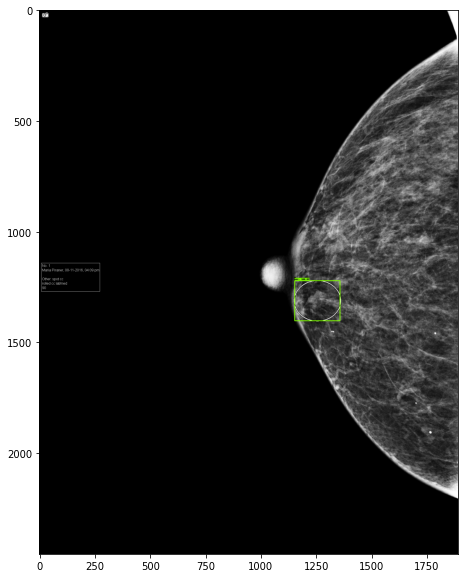

In [40]:
### code to double check roi detection before running it
## OLD CODE - intermediary step
df_eval = pd.read_csv('OD_Files/eval.csv')
i=random.choice(range(len(df_eval)))
print(i)
image_np = load_image_into_numpy_array(df_eval.roi_img_final[i])
print(df_eval.roi_img_final[i])
print("flip_flag: ", df_eval.flip_flag[i])
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
#image_np_with_detections = cv2.flip(image_np_with_detections, 1)

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.2, #EXPERIMENT WITH THIS THRESHOLD
      agnostic_mode=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image_np_with_detections)
plt.show()

# testing cv2 open
roi_path = '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c611328bce0a2.png'
# check bit depth
img_sitk = sitk.ReadImage(roi_path)
img_np = sitk.GetArrayFromImage(img_sitk)
print(img_np.dtype)
# uses Raman's code to extract the ROI from the screen save image
img = load_image_into_numpy_array(roi_path) #Load the image in a numpy array
print(img.shape)
print(img.dtype)
if(len(img.shape) != 3):
    img = load_image_into_numpy_array(roi_path, cvt_to_grayscale=True)
    shape_change_flag = 1
#This return different objects that a model detects in an image
detections = get_detections(roi_path, cvt_to_grayscale=True)
#This function return the coordinates and the classes
coords, classes = get_coordinates(roi_path, detections, img.shape[0], img.shape[1], threshold=0.5, 
                                          verbose=False, plot_image=True, save_image=False, chosen_model=chosen_model, 
                                          cvt_to_grayscale=False, return_image=False)

In [27]:
def checkImageSimilarity(roi_path, mammo_paths, sim_metric, hist_matcher, img_on=False):
    # reading the ROI image
    roi_img_path = roi_path  # directly put the path
    roi_sitk = sitk.ReadImage(roi_img_path)
    roi_np = sitk.GetArrayFromImage(roi_sitk)
    
    # flipping the ROI image
    roi_np_flip = np.flip(roi_np, axis=1)

    # initializing for choosing the best
    best_sim = 0
    best_match = None
    flip_flag = 0
    
    # for all other files
    for i in mammo_paths:
        # loads and shows the next image
        img_path = i # directly put the path
        img_sitk = sitk.ReadImage(img_path)
        img_sitk = hist_matcher.Execute(img_sitk, roi_sitk)
        img_np = sitk.GetArrayFromImage(img_sitk)
        
        # check the aspect ratio of the image (sanity check and speeds up code by filtering out images)
        if np.round(roi_np.shape[0]/roi_np.shape[1], 2) != np.round(img_np.shape[0]/img_np.shape[1], 2):
            continue
        
        # resizing and changing the datatype from float (result of resize) to unit8 for similarity check compatability
        img_np_resize = resize(img_np, roi_np.shape, preserve_range=True).astype(np.uint16)
        
        # converts to sitk images again to do similarity check
        roi_img = sitk.GetImageFromArray(roi_np)
        img_img = sitk.GetImageFromArray(img_np_resize)
        roi_flip_img = sitk.GetImageFromArray(roi_np_flip)
        
        # gets similarity matrix of original
        sim_metric.Execute(roi_img, img_img)
        sim_o = sim_metric.GetSimilarityIndex()
    
        # gets similarity matrix of flipped
        sim_metric.Execute(roi_flip_img, img_img)
        sim_f = sim_metric.GetSimilarityIndex()
        
        # get scale factor (between the roi image and the mammo)
        x_ratio = img_np.shape[1]/roi_np.shape[1]
        y_ratio = img_np.shape[0]/roi_np.shape[0]
        scale_factor = np.mean([x_ratio, y_ratio])
    
        # get max similarity for the image
        if sim_o > sim_f:
            img_sim_max = sim_o
            flip_flag = 0
        else:
            img_sim_max = sim_f
            flip_flag = 1
            
        # if the image similarity is better than previous ones and update with better ones
        if img_sim_max > best_sim: 
            best_sim = img_sim_max
            best_match = i
            best_img = img_np_resize
            final_flip = flip_flag
            final_scale = scale_factor
            if sim_o == best_sim:
                best_roi = roi_np
            else:
                best_roi = roi_np_flip
        # if images should be shown:
        if img_on:
            # shows all figures side by side:
            f = plt.figure(figsize=(10,15))
            f.add_subplot(1,3, 1)
            plt.imshow(roi_np, cmap='gray')
            plt.title('ROI')
            f.add_subplot(1,3, 2)
            plt.imshow(img_np_resize, cmap='gray')
            plt.title('Mammo')
            f.add_subplot(1,3, 3)
            plt.imshow(roi_np_flip, cmap='gray')
            plt.title('Flipped ROI')
            plt.show(block=True)
            print('Similarity: {}\n'.format(img_sim_max))
        
        print(i)
    print(best_match)
    
    return best_sim, best_match, best_img, best_roi, final_flip, scale_factor

In [28]:
# visualization code with option to save images
def visual_compare(roi_path, match_path, coords, flip_flag, scale_factor, detected_num, save_path=None):
    # set up figure
    f = plt.figure(figsize=(20,7))
    # read roi image
    roi_sitk = sitk.ReadImage(roi_path)
    roi_np = sitk.GetArrayFromImage(roi_sitk)
    # if flip_flag = 1, flip the roi image
    if flip_flag == 1:
        roi_np = np.flip(roi_np, axis=1)
        roi_width = roi_np.shape[1]
        coords = [coords[0], roi_width - coords[3], coords[2], roi_width - coords[1]]
    # plot roi image
    f.add_subplot(1,4, 1)
    ax = plt.gca()
    rect = patches.Rectangle((coords[1],coords[0]), coords[3]-coords[1], coords[2]-coords[0],linewidth=2,edgecolor='red',fill = False)
    ax.add_patch(rect)
    plt.imshow(roi_np, cmap='gray')
    plt.title('ScreenSave, flip={}'.format(flip_flag))
    # coordinate system use to get the patch
    roi_seg = roi_np[coords[0]:coords[2],coords[1]:coords[3]]
    f.add_subplot(1,4, 2)
    plt.imshow(roi_seg, cmap='gray')
    plt.title('SC_ROI')
    # getting the mammogram image
    mam_sitk = sitk.ReadImage(match_path)
    mam_np = sitk.GetArrayFromImage(mam_sitk)
    # scaling up the roi_coordinates to the mammogram image
    mam_coord = [int(np.round(i*scale_factor)) for i in coords]
    f.add_subplot(1,4, 4)
    ax = plt.gca()
    rect = patches.Rectangle((mam_coord[1],mam_coord[0]), mam_coord[3]-mam_coord[1], mam_coord[2]-mam_coord[0],linewidth=2,edgecolor='red',fill = False)
    ax.add_patch(rect)
    plt.imshow(mam_np, cmap='gray')
    plt.title('Raw_Mammo')
    mam_seg = mam_np[mam_coord[0]:mam_coord[2],mam_coord[1]:mam_coord[3]]
    f.add_subplot(1,4, 3)
    plt.imshow(mam_seg, cmap='gray')
    plt.title('Mammo_ROI')
    if save_path != None:
        # filename has the final part '_n' where n is the index of the ROI detected (multiple ROIs would be n=1+)
        try:
            plt.savefig(os.path.join(save_path, '{}_{}{}'.format(match_path.split('/')[-1].replace('.png', ''), detected_num, '.png')))
        except:
            print('savefig error')
    else:
        plt.show()
    return mam_coord

In [29]:
# actual ROI extraction step in a function
def ROI_Extract(n, metric, matcher, ssc_df, twoD_df, save_path=None):
    # gets the roi_path from joining the path and filename from the same column
    roi_path = os.path.join(ssc_df.iloc[n]['path'], ssc_df.iloc[n]['filename'])
    # gets the list of files from first getting a list of files with the same path
    mammo_files = list(twoD_df[twoD_df['path'] == ssc_df.iloc[n]['path']].filename)
    mammo_paths = [os.path.join(ssc_df.iloc[n]['path'], file) for file in mammo_files]
    # runs the similarity check
    sim_score, match_path, img_array, roi_array, flip_flag, scale_factor = checkImageSimilarity(roi_path, mammo_paths, metric, matcher, False)
    
    # double checking scale_factor
    img_sitk = sitk.ReadImage(match_path)
    img_np = sitk.GetArrayFromImage(img_sitk)
    #print('mammogram bit depth: {}'.format(img_np.dtype))
    roi_sitk = sitk.ReadImage(roi_path)
    roi_np = sitk.GetArrayFromImage(roi_sitk)
    #print('screen save bit depth: {}'.format(roi_np.dtype))
    
    # if scale factor is wrong, correct to the right scale factor
    if np.round(scale_factor, 3) != np.round(img_np.shape[0]/roi_np.shape[0], 3):
        print('Scale factor is off, correcting')
        scale_factor = img_np.shape[0]/roi_np.shape[0]
    
    # uses Raman's code to extract the ROI from the screen save image
    img = load_image_into_numpy_array(roi_path) #Load the image in a numpy array
    if(len(img.shape) != 3):
        img = load_image_into_numpy_array(roi_path, cvt_to_grayscale=True)
        shape_change_flag = 1
    #This return different objects that a model detects in an image
    detections = get_detections(roi_path, cvt_to_grayscale=True)
    #This function return the coordinates and the classes
    coords, classes = get_coordinates(roi_path, detections, img.shape[0], img.shape[1], threshold=0.5, 
                                          verbose=False, plot_image=False, save_image=False, chosen_model=chosen_model, 
                                          cvt_to_grayscale=False, return_image=False)
    
    # ROI coordinates:
    extracted_coord = []
    matching_mammo = []
    # going through all detected ROIs
    for i in range(len(classes)):
        # if the detection is an ROI
        if classes[i] == 'ROI':
            # extract and save the ROI visualization
            mam_coord = visual_compare(roi_path, match_path, coords[i], flip_flag, scale_factor, detected_num=i, save_path=save_path)
            # add to list of coordinates
            extracted_coord.append(mam_coord)
            matching_mammo.append(match_path)

    plt.close()
    plt.clf()
    
    return extracted_coord, matching_mammo

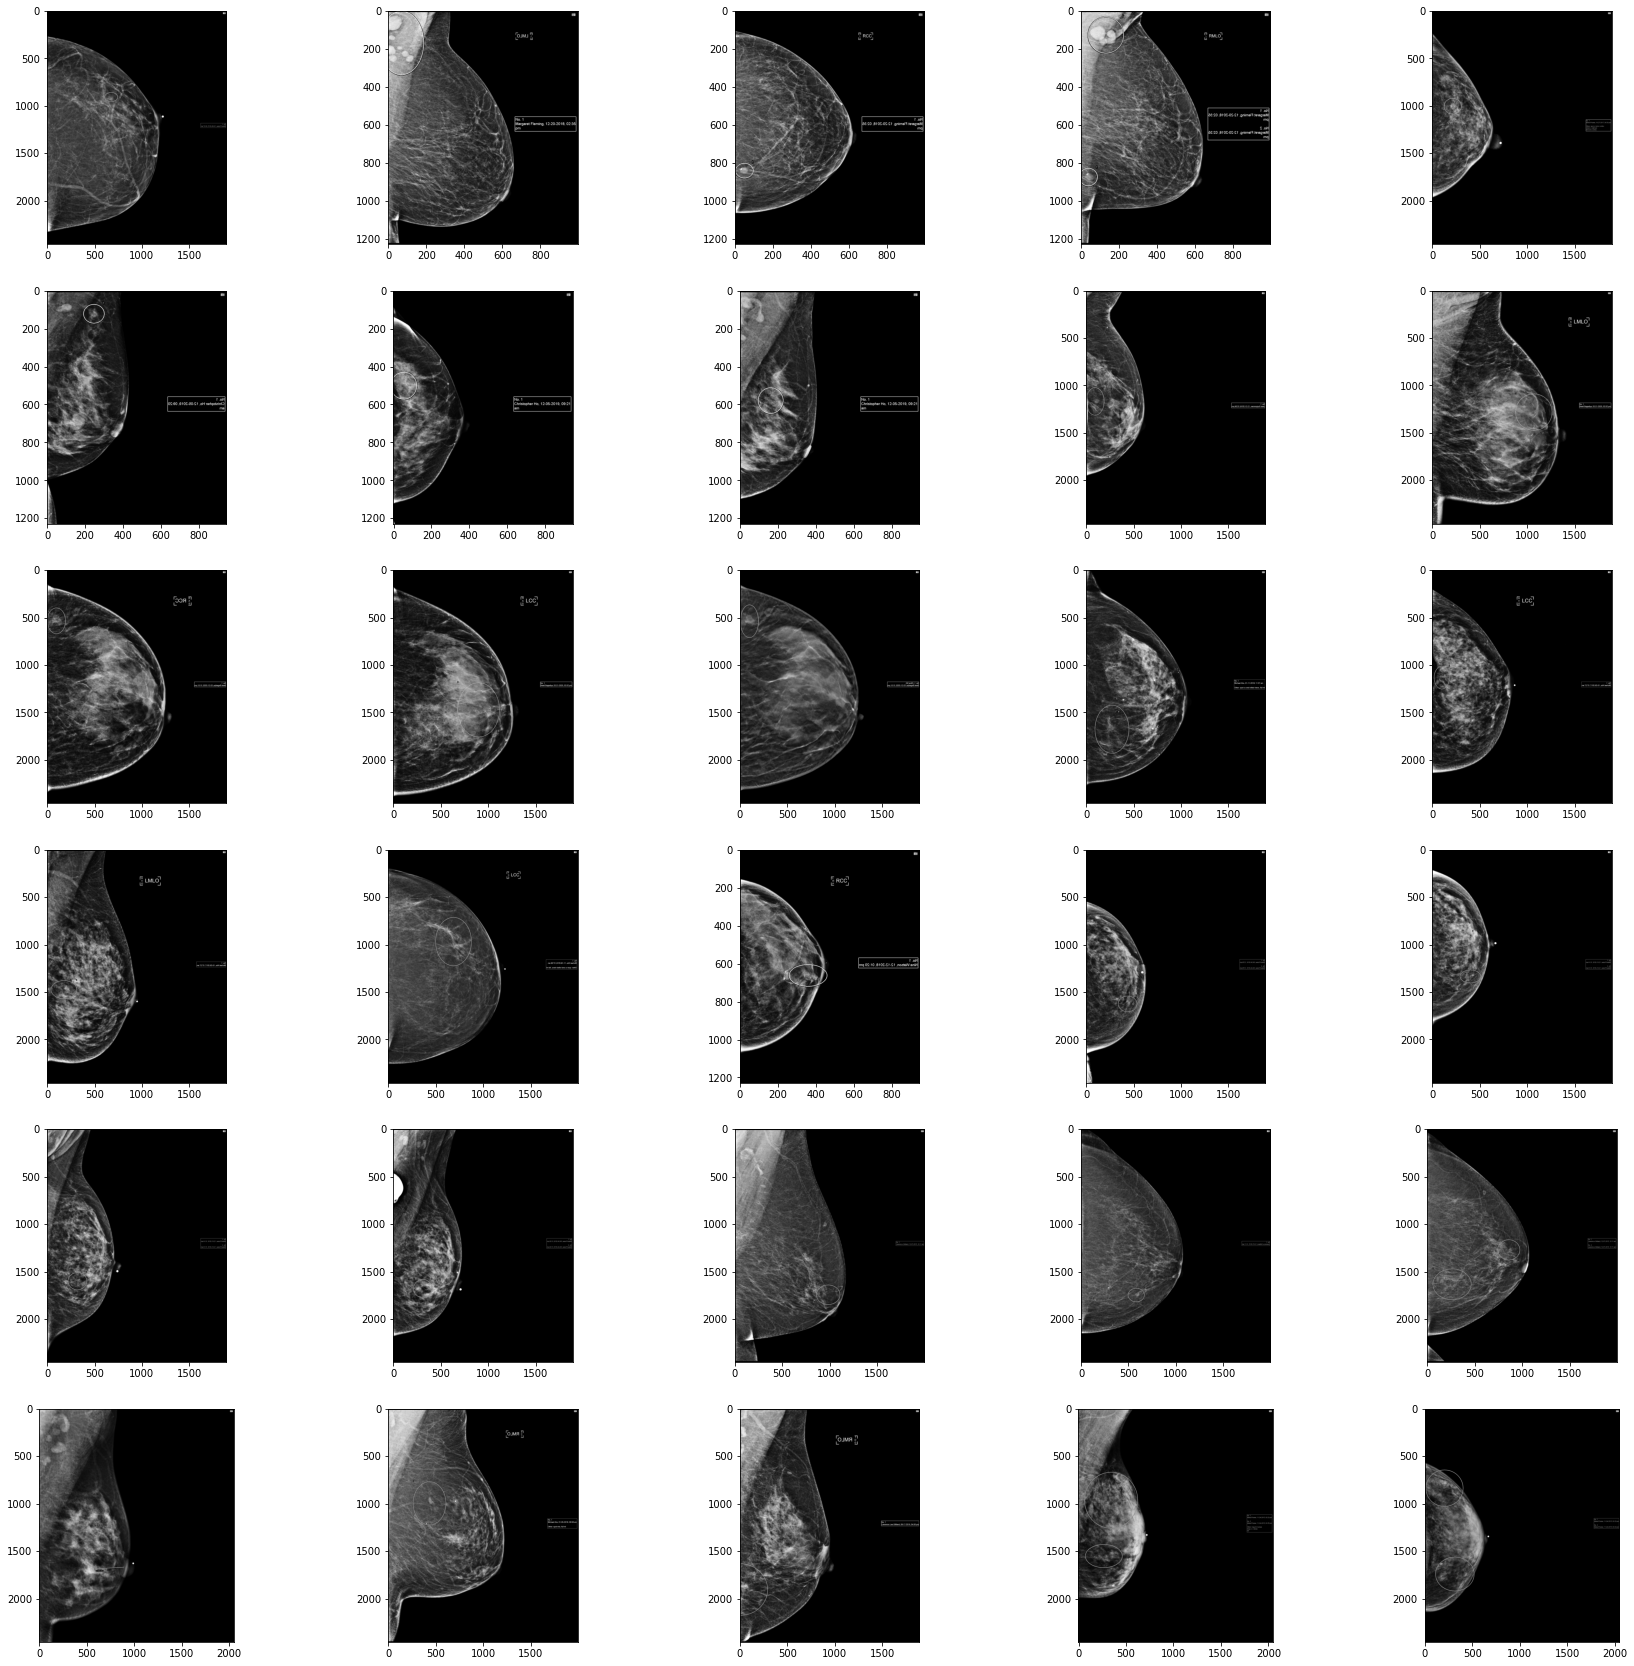

In [34]:
f = plt.figure(figsize=(30,30))
for i in range(30):
    roi_path = os.path.join(mergeddf_ssc.iloc[i]['path'], mergeddf_ssc.iloc[i]['filename'])
    roi_sitk = sitk.ReadImage(roi_path)
    roi_np = sitk.GetArrayFromImage(roi_sitk)
    f.add_subplot(6, 5, i+1)
    plt.imshow(roi_np, cmap='gray')
plt.show()

In [35]:
# setting up metrics
metric = sitk.SimilarityIndexImageFilter()  # set similarity metric as SimilarityIndexImageFilter
# set up the histogram matcher
matcher = sitk.HistogramMatchingImageFilter()
matcher.SetNumberOfHistogramLevels(256)
matcher.SetNumberOfMatchPoints(7)
matcher.ThresholdAtMeanIntensityOn()
# copy dataframes
new_HITIdf_ssc = mergeddf_ssc.copy()
new_HITIdf_2d = mergeddf_2d.copy()

In [ ]:
# setup Coordinates
ROI_coords = []
ROI_matching_mammo = []
compare_save_path = '/home/jupyter-jjjeon3/Collaboratory/Jason_BR0/ROI_extraction_7.1.21_kheiron_cohort1/'
for n in range(len(new_HITIdf_ssc)):  # HITIdf_ssc.shape[0]
    try:
        extracted_coord, matching_mammo = ROI_Extract(n, metric, matcher, new_HITIdf_ssc, new_HITIdf_2d, save_path=compare_save_path)
    except:
        print('No ROI detected')
        extracted_coord = []
        matching_mammo = []
    print('Progress:{}/{}'.format(n+1, new_HITIdf_ssc.shape[0]))
    ROI_coords.append(extracted_coord)
    ROI_matching_mammo.append(matching_mammo)

test_df = new_HITIdf_ssc.copy()
test_df['ROI_coord'] = ROI_coords
test_df['Matching_Mammo'] = ROI_matching_mammo
test_df.head()

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/f92cc52dcbd4ea9c17b0b7c0fc8fadb3973c817f33edfd265f77846b.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/0c060bcc03718b1cff76efa86d5345c2d17964befbefdc43abf6967a.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/a88852923abff20e80b406cc0d2e2b37ef194749c346509e1eae0849.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/673a142b63ff991f901e26ecf6483aa2f4bad72a2676dd866ed1a38c/821299aae48ba91edbc49170dfb2b62c8c064212000cd1be705a4483/c928d1aca0abf1775aa850dc3e4798f288b4478ecf017e3cafb47af4.png
/data/mammo/png_kheiron/kheiron_code/cohort_1/ex

In [37]:
# save extracted SSC files with ROI coordinates
test_df.to_csv('ROI_extracted_SSC.csv')
test_df.head()  # and show csv

,Unnamed: 0,Unnamed: 0.1,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,...,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename,spot-mag,ROI_coord,Matching_Mammo
0,0,100,NaN,84025.716,NaN,NaN,NaN,NaN,16.0,12.0,...,4378856307268605,2015-04-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c61...,0,"[[1165, 823, 1294, 1000]]",[/data/mammo/png_kheiron/kheiron_code/cohort_1...
1,1,358,NaN,143644.457,NaN,NaN,NaN,NaN,16.0,12.0,...,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,976c4edc8b03490104da995116cd8ec7f4b6e511a3a0c3...,0,"[[3, 0, 1111, 624]]",[/data/mammo/png_kheiron/kheiron_code/cohort_1...
2,2,363,NaN,143644.458,NaN,NaN,NaN,NaN,16.0,12.0,...,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,cfd759deb15ba975a087b60869fd9efcdf82a08345e885...,0,"[[2678, 17, 2932, 314]]",[/data/mammo/png_kheiron/kheiron_code/cohort_1...
3,3,370,NaN,143644.460,NaN,NaN,NaN,NaN,16.0,12.0,...,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,087b65d2a49ee7ac0f38df44ec4a0fdd001330ce6b3801...,0,"[[2768, 0, 3065, 280], [103, 123, 740, 734]]",[/data/mammo/png_kheiron/kheiron_code/cohort_1...
4,4,442,NaN,80603.015,NaN,NaN,NaN,NaN,16.0,12.0,...,7745120485365371,2017-12-07 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,333ba5ab8dc3581a62ba92c096bb578a6c5c3afc6d87bd...,0,"[[1249, 176, 1474, 417]]",[/data/mammo/png_kheiron/kheiron_code/cohort_1...


In [82]:
# checking unique anonymized acc in scc list
ssc_acc = list(set(test_df.acc_anon.to_list()))
len(ssc_acc)

1492

In [83]:
# checking unique anonymized acc in 2d list
new_HITIdf_2d_acc = list(set(new_HITIdf_2d.acc_anon.to_list()))
len(new_HITIdf_2d_acc)

35863

In [87]:
# double checking to make sure the filenames match in both csvs
flag = 0
for x in ssc_acc:
    if x in new_HITIdf_2d_acc:
        flag += 1
    else:
        print(x)
print(flag)
# weirdly there's one accession in screensave thats not in 2d

8544563391041065
1491
3785092026294273


In [131]:
os.getcwd()

'/home/jupyter-jjjeon3'

In [133]:
# copying 1000 samples for Hari and Sophie
import shutil
samples_1 = mergeddf_ssc.sample(1000)
samples_2 = mergeddf_2d.sample(1000)
for i in range(len(samples_1)):
    shutil.copy(samples_1['png_path'].iloc[i], '/home/jupyter-jjjeon3/Collaboratory/Jason_BR0/Fullview_classification_samples/' + samples_1['png_path'].iloc[i].split('/')[-1])
    shutil.copy(samples_2['png_path'].iloc[i], '/home/jupyter-jjjeon3/Collaboratory/Jason_BR0/Fullview_classification_samples/' + samples_2['png_path'].iloc[i].split('/')[-1])

In [129]:
print(samples_1['png_path'].iloc[0])
print('/Collaboratory/Jason_BR0/Fullview_classification_samples/' + samples_2['png_path'].iloc[0].split('/')[-1])

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/9af37093a4b318f054649269ffa7c0fd7ba151673d64e9cc48a4986a/ffc5cfda7473c2ad55e7457337d65c33ca6cc83e22eaded211dfac41/7e46ff6e3ac9f05d433173ad3932de2367319f7ee7a355300bb8b245.png
/Collaboratory/Jason_BR0/Fullview_classification_samples/7abfe179d1b01426100c21daa64b90b47503546cc3baa9e20fd0579d.png


['/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/25bfd8877ad496782cb7652746bdfbc945a0ae3d7666db7975432263.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/9c8ea2b7367502d09d8e2038490dab9b2e355b5ecb264cbf3514e420.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0ee7.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/42450c885d1809ee0c52f99712e42e9e49145e6d162d405ef4d7e33e.png', '/data/mammo/png_kheiron/kheiron_co

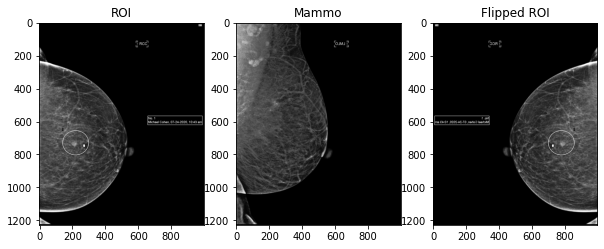

Similarity: 0.7847118391954941



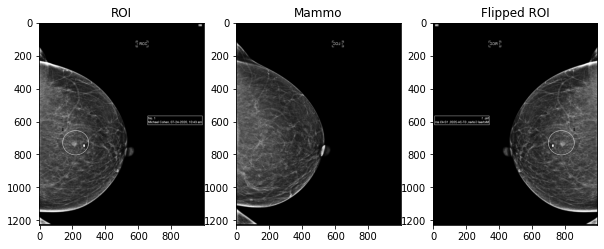

Similarity: 0.9648949326400498



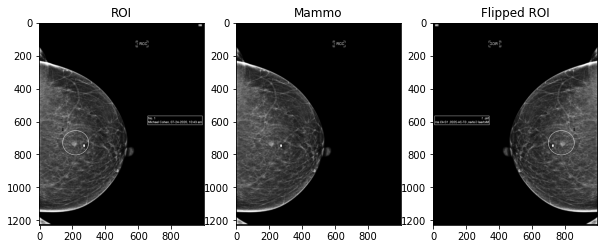

Similarity: 0.9929028443070175



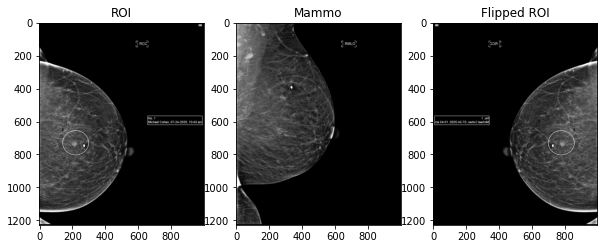

Similarity: 0.7293462359153429



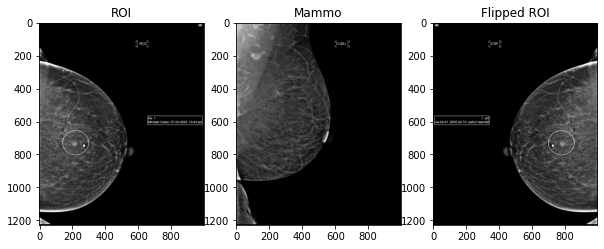

Similarity: 0.7074301793567971

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0ee7.png
progress:1/3174
['/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/25bfd8877ad496782cb7652746bdfbc945a0ae3d7666db7975432263.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/9c8ea2b7367502d09d8e2038490dab9b2e355b5ecb264cbf3514e420.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0

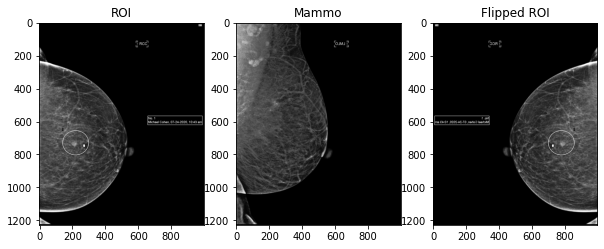

Similarity: 0.7847118391954941



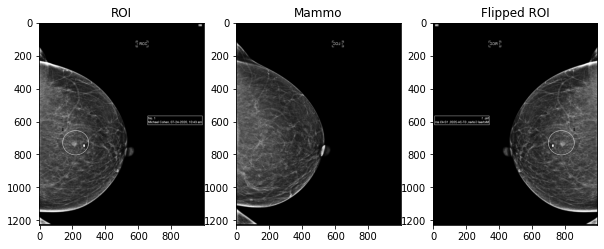

Similarity: 0.9648949326400498



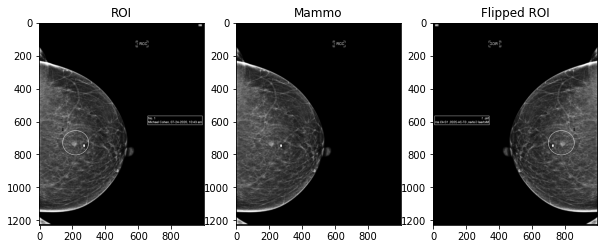

Similarity: 0.9929028443070175



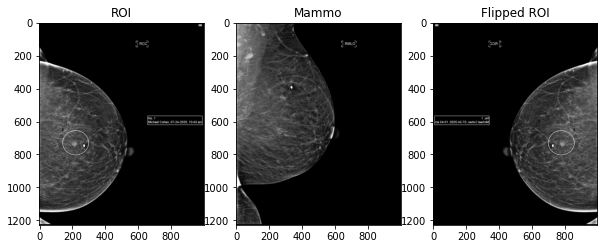

Similarity: 0.7293462359153429



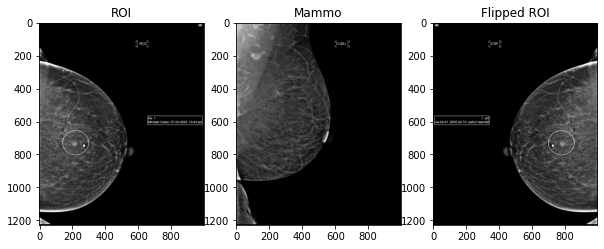

Similarity: 0.7074301793567971

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0ee7.png
progress:2/3174
['/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/25bfd8877ad496782cb7652746bdfbc945a0ae3d7666db7975432263.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/9c8ea2b7367502d09d8e2038490dab9b2e355b5ecb264cbf3514e420.png', '/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0

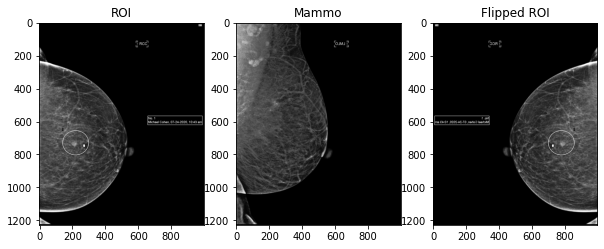

Similarity: 0.7847118391954941



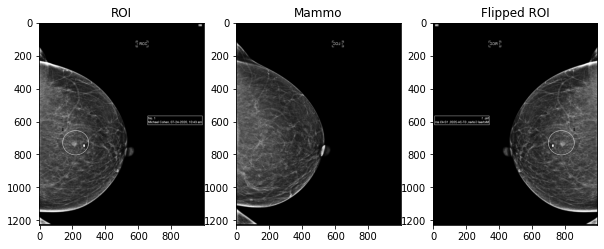

Similarity: 0.9648949326400498



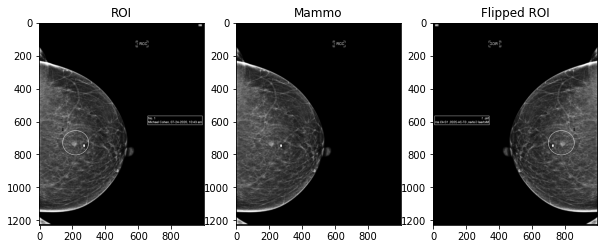

Similarity: 0.9929028443070175



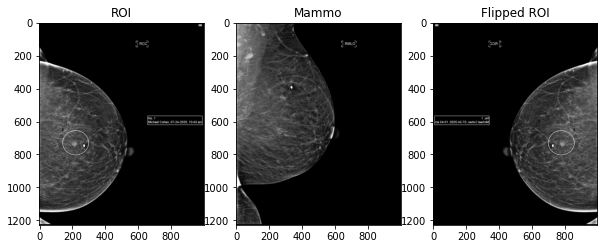

Similarity: 0.7293462359153429



KeyboardInterrupt: 

In [120]:
# get matching mammograms (temp, fixed in code to do this automatically)
new_HITIdf_ssc = mergeddf_ssc.copy()
new_HITIdf_2d = mergeddf_2d.copy()
ssc_df = new_HITIdf_ssc
twoD_df = new_HITIdf_2d
match_paths = []
for i in range(len(ssc_df)):
    # gets the roi_path from joining the path and filename from the same column
    roi_path = os.path.join(ssc_df.iloc[n]['path'], ssc_df.iloc[n]['filename'])
    # gets the list of files from first getting a list of files with the same path
    mammo_files = list(twoD_df[twoD_df['path'] == ssc_df.iloc[n]['path']].filename)
    mammo_paths = [os.path.join(ssc_df.iloc[n]['path'], file) for file in mammo_files]
    print(mammo_paths)
    # runs the similarity check
    sim_score, match_path, img_array, roi_array, flip_flag, scale_factor = checkImageSimilarity(roi_path, mammo_paths, metric, matcher, True)
    print(match_path)
    match_paths.append(match_path)
    print('progress:{}/{}'.format(i+1, len(ssc_df)))
test_df['Matching_Mammo'] = match_paths

In [93]:
test_df.head()

,Unnamed: 0,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,BodyPartExamined,...,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename,ROI_coord,Matching_Mammo
0,100,NaN,84025.716,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,27942877,4378856307268605,2015-04-16 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,c0ab71c90ec1023dcce5a38d8cfe9e5ce4d1e8d45e2c61...,"[[1165, 823, 1294, 1000]]",/data/mammo/png_kheiron/kheiron_code/cohort_1/...
1,358,NaN,143644.457,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,976c4edc8b03490104da995116cd8ec7f4b6e511a3a0c3...,"[[3, 0, 1111, 624]]",/data/mammo/png_kheiron/kheiron_code/cohort_1/...
2,363,NaN,143644.458,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,cfd759deb15ba975a087b60869fd9efcdf82a08345e885...,"[[2678, 17, 2932, 314]]",/data/mammo/png_kheiron/kheiron_code/cohort_1/...
3,370,NaN,143644.460,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,49677506,8010398258948596,2018-08-05 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,087b65d2a49ee7ac0f38df44ec4a0fdd001330ce6b3801...,"[[2768, 0, 3065, 280], [103, 123, 740, 734]]",/data/mammo/png_kheiron/kheiron_code/cohort_1/...
4,442,NaN,80603.015,NaN,NaN,NaN,NaN,16.0,12.0,BREAST,...,21827263,7745120485365371,2017-12-07 00:00:00,2,NaN,ROI_SSC,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,333ba5ab8dc3581a62ba92c096bb578a6c5c3afc6d87bd...,"[[1249, 176, 1474, 417]]",/data/mammo/png_kheiron/kheiron_code/cohort_1/...


In [95]:
test_df.Matching_Mammo[0]

'/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/3e30f201f0c170539b198efa1d396479d8b0f92248cf9b6915bbe9ad/15e8c2dea0fa2bc1b05a2bb9414c1b43f98ca556400c4fb1d9e0c5c1/38e8f9e2bb04c3058ff27914f2f3a4d2a854caa1df6e03294f4a0ee7.png'

In [94]:
new_HITIdf_2d.head()

,Unnamed: 0,AcquisitionContextSequence,AcquisitionTime,0_AnatomicRegionSequence_CodeMeaning,0_AnatomicRegionSequence_CodeValue,0_AnatomicRegionSequence_CodingSchemeDesignator,AnodeTargetMaterial,BitsAllocated,BitsStored,BodyPartExamined,...,png_path,png_path_old,empi_anon,acc_anon,study_date_anon,DeriveFlag,ImageLateralityFinal,FinalImageType,path,filename
0,0,[],93624.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,66685715,7208547536889815,2017-05-15 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,b9c9d54f8480da0dae0269f2e56b5c56e44133143093bf...
1,1,[],135938.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,f10e28e9180e69b0c13ace33ab90cda157dd23e7365752...
2,3,[],135833.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,R,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,95080bb97a3ed743ee3ef470edea8ffc4c53e3e5ff58c4...
3,6,[],140052.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,25a5990dd8f2995283580103937ae67b55490d32b9184f...
4,7,[],140230.0,Breast,T-04000,SRT,TUNGSTEN,16.0,12.0,BREAST,...,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,/opt/ssd-data/mammo/png_kheiron/cohort_1_rest...,30864920,7774461277054123,2019-08-05 00:00:00,0,L,2D,/data/mammo/png_kheiron/kheiron_code/cohort_1/...,072d248d21b84be09c17263e5a99043ab7e00be94ea71f...


In [118]:
test_df.Matching_Mammo[0] == test_df.Matching_Mammo[100]

True

In [116]:
test_df['ROI_coord'][test_df['Matching_Mammo'] == test_df.Matching_Mammo[0]]

0                          [[1165, 823, 1294, 1000]]
1                                [[3, 0, 1111, 624]]
2                            [[2678, 17, 2932, 314]]
3       [[2768, 0, 3065, 280], [103, 123, 740, 734]]
4                           [[1249, 176, 1474, 417]]
                            ...                     
3169                        [[1389, 240, 1935, 644]]
3170                      [[2202, 2083, 2670, 2482]]
3171                      [[2767, 2215, 3167, 2594]]
3172                       [[2035, 717, 2362, 1084]]
3173                        [[2191, 480, 2675, 994]]
Name: ROI_coord, Length: 3174, dtype: object

In [100]:
mammo_path = new_HITIdf_2d.iloc[0,-2] + '/' +new_HITIdf_2d.iloc[i,-1]
print(mammo_path)
roi = test_df['ROI_coord'][test_df['Matching_Mammo'] == mammo_path]
print(roi)
if roi.empty:
    print('empty')

/data/mammo/png_kheiron/kheiron_code/cohort_1/extracted-images/e8957017d28da3033157289d640067281a6d15a34a3318fe5a4b2645/6040636f03f9e94183171b0e23d4a8f5bf19e94f98fe53eee3e20931/788607723674ba210930ffec5678d54076fff1714b90fa188446dbf5.png
Series([], Name: ROI_coord, dtype: object)
empty


In [111]:
# map mammogram ROI coordinates to 2D mammograms via accession
mammo_roi = []
for i in range(len(new_HITIdf_2d)):
    mammo_path = new_HITIdf_2d.iloc[i,-3] + '/' +new_HITIdf_2d.iloc[i,-2]
    roi = test_df['ROI_coord'][test_df['Matching_Mammo'] == mammo_path]
    if roi.empty:
        mammo_roi.append([])
    else:
        mammo_roi.append(roi.item())
new_HITIdf_2d['ROI_coord'] = mammo_roi
new_HITIdf_2d.head()

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
t = new_HITIdf_2d.ROI_coord.to_list()
num = 0
for i in t:
    print(i)
    if i != []:
        num += 1
print(num)